In [384]:
using PyPlot; plt = PyPlot
using Keldysh; kd = Keldysh

Keldysh

In [436]:
nt = 100
ntau = 20
tmax = 5.0
β = 1.0
t = 1.0
ϵ = 0.2

c = kd.twist(kd.FullContour(tmax=tmax, β=β))
grid = kd.FullTimeGrid(c, nt, ntau);

G_ref_tti = kd.TimeInvariantFullTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);
#G_ref_tti = kd.TimeInvariantFullTimeGF(kd.DeltaDOS(ϵ), grid);

# TTI Dyson

$$
(i \partial_t - H - \Sigma^R \ast ) G^{tv} = \Sigma^{tv} \ast G^M
$$

$$
\Sigma^R(t) = \xi \Sigma^{tv}(t, \beta) - \Sigma^{tv}(t,  0)
$$

$$
i \partial_t G^{tv}(t_i, \tau_j) \approx \frac{i}{\Delta t} \left( G^{tv}(t_i, \tau_j) - G^{tv}(t_{i-1}, \tau_j) \right)
$$

$$
( \frac{i}{\Delta t} - H ) G^{tv}(t_i, \tau_j) = \frac{i}{\Delta t} G^{tv}(t_{i-1}, \tau_j)
$$


## LHS integral

$$
\Sigma^R \ast G^{tv} = \int_0^t d\bar{t} \, \Sigma^R(t - \bar{t}) G^{tv}(\bar{t}, \tau) 
\approx 
\Delta t \sum_{j=1}^i'
\Sigma^R(t_i - t_j) G^{tv}(t_j, \tau)
$$

$$
\left( \frac{i}{\Delta t} - H - \frac{\Delta t}{2} \Sigma^R(0) \right) G^{tv}(t_i, \tau_j) 
= 
\frac{i}{\Delta t} G^{tv}(t_{i-1}, \tau_j) + \Delta t \sum_{j=2}^{i-1} \Sigma^R(t_i - t_j) G^{tv}(t_j, \tau) + \frac{\Delta t}{2} \Sigma^R(t_i) G^{tv}(0, \tau)
$$



# RHS $\Sigma^{tv} \ast G$ term

$$
\Sigma^{tv} \ast G^M
=
\int_0^\beta d\bar{\tau} \, \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
= 
\int_0^\tau d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) \xi G^M(\beta + \bar{\tau} - \tau)
+
\int_\tau^\beta d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
$$


- Bethe lattice test

In [519]:
function integrate_tti_retarded(Σ, G, t, τ)

    grid = G.grid
    dt = step(grid, forward_branch)
    
    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    I = Array{ComplexF64}(undef, norb, norb)
    I .= 0.0
        
    ΣR = Int(Σ.ξ) * Σ[:, :, t, τβ] - Σ[:, :, t, τ0]
    I += 0.5 * dt * ΣR * G[:, :, t0, τ]

    for tp in grid[forward_branch][2:t.ridx - 1]
        tmtp = grid[forward_branch][t.ridx - tp.ridx + 1]
        ΣR = Int(Σ.ξ) * Σ[:, :, tmtp, τβ] - Σ[:, :, tmtp, τ0]
        I += dt * ΣR * G[:, :, tp, τ]
    end
    
    return I
    
end;

In [552]:
function integrate_tti_mixed(Σ, G, t, τ)

    grid = G.grid
    dτ = -imag(step(grid, imaginary_branch))

    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    Q = Array{ComplexF64}(undef, norb, norb)
    Q .= 0.0
        
    # Trapz on the two continuous segments O(Δt^{-2})
        
    for τb in grid[imaginary_branch][τ0.ridx:τ.ridx]
        βpτbmτ = grid[imaginary_branch][τβ.ridx + τb.ridx - τ.ridx]
        s = τb.ridx == τ0.ridx || τb.ridx == τ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * Int(G.ξ) * G[:, :, βpτbmτ, τ0]
    end
        
    for τb in grid[imaginary_branch][τ.ridx:end]
        τbmτ = grid[imaginary_branch][τb.ridx - τ.ridx + 1]
        s = τb.ridx == τ.ridx || τb.ridx == τβ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * G[:, :, τbmτ, τ0]
    end
            
    # Rieman sum over discontinuity O(Δt^{-1})    
    #for τb in grid[imaginary_branch][τ0.ridx:τβ.ridx]
    #    Q += -im * dτ * Σ[:, :, t, τb] * G[:, :, τb, τ]
    #end

    return Q

end;

In [553]:
function timestep_tti!(G, H, Σ, t, τ)

    grid = G.grid

    # -- Copy from imaginary time branch for t = 0
    
    if t.ridx == 1
        τ0 = first(grid[imaginary_branch])
        τβ = last(grid[imaginary_branch])
        βmτ = grid[imaginary_branch][τβ.ridx - τ.ridx + 1]
        G[:, :, t, τ] = Int(G.ξ) * G[:, :, βmτ, τ0]
        return
    end

    # -- Solve integrol diff Dyson eq. for t > 0
    
    I = integrate_tti_retarded(Σ, G, t, τ) # ΣR * Gtv
    Q = integrate_tti_mixed(Σ, G, t, τ) # Σtv * GM

    dt = step(grid, forward_branch)
    tm1 = grid[forward_branch][t.ridx - 1] # Previous time
    
    b = 1im/dt * G[:, :, tm1, τ] + I + Q    
    A = 1im/dt * la.I - H - 0.5 * dt * Σ[:, :, t0, τ]        

    G[:, :, t, τ] = A \ b
    
end;

In [554]:
using LinearAlgebra; la = LinearAlgebra

Σ = kd.TimeInvariantFullTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);
G = kd.TimeInvariantFullTimeGF(grid);

G.mat.data[:] = G_ref_tti.mat.data

H = Array{ComplexF64}(undef, 1, 1)
H[1, 1] = ϵ

for t in grid[forward_branch][1:end]
    for τ in grid[imaginary_branch]
        timestep_tti!(G, H, Σ, t, τ)
    end
end

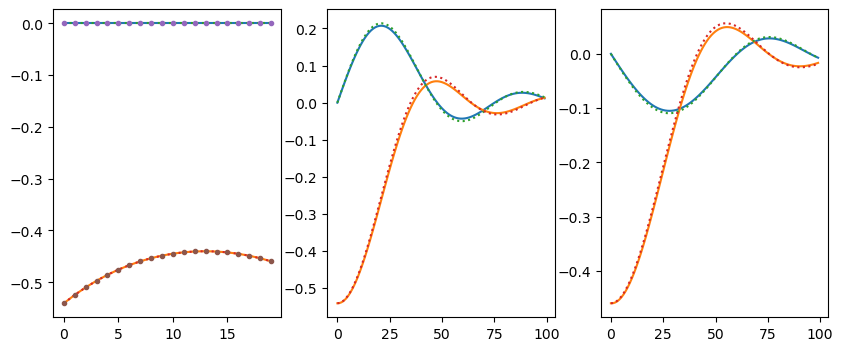

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x38969d900>

In [555]:
subp = [1, 3, 1]
plt.figure(figsize=(10, 4))

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, :, 1]))
plt.plot(imag(G.rm.data[1, 1, :, 1]))
plt.plot(real(G_ref_tti.rm.data[1, 1, :, 1]), ":")
plt.plot(imag(G_ref_tti.rm.data[1, 1, :, 1]), ":")
plt.plot(real(G.mat.data[1, 1, :, 1]), ".")
plt.plot(imag(G.mat.data[1, 1, :, 1]), ".")


plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, 1, :]))
plt.plot(imag(G.rm.data[1, 1, 1, :]))
plt.plot(real(G_ref_tti.rm.data[1, 1, 1, :]), ":")
plt.plot(imag(G_ref_tti.rm.data[1, 1, 1, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, end, :]))
plt.plot(imag(G.rm.data[1, 1, end, :]))
plt.plot(real(G_ref_tti.rm.data[1, 1, end, :]), ":")
plt.plot(imag(G_ref_tti.rm.data[1, 1, end, :]), ":")

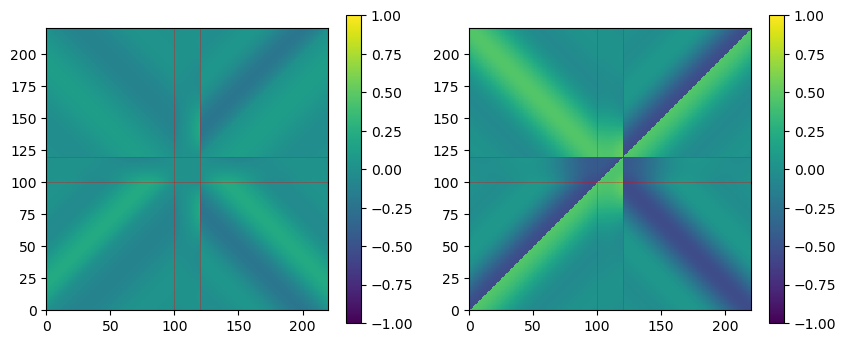

(0.0, 220.0, 0.0, 220.0)

In [439]:
G_ref = kd.GenericTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);

subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G_ref.data.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)

N = 2*nt + ntau
plt.plot([0, N], [nt, nt], "r-", alpha=0.5, lw=0.5)
plt.plot([0, N], [nt + ntau , nt + ntau], "r-", alpha=0.5, lw=0.5)
plt.plot([nt, nt], [0, N], "r-", alpha=0.5, lw=0.5)
plt.plot([nt + ntau , nt + ntau], [0, N], "r-", alpha=0.5, lw=0.5)
plt.colorbar()
plt.axis("square")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G_ref.data.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)

N = 2*nt + ntau
plt.plot([0, N], [nt, nt], "r-", alpha=0.5, lw=0.5)
plt.plot([0, N], [nt + ntau , nt + ntau], "r-", alpha=0.5, lw=0.5)
plt.plot([nt, nt], [0, N], "r-", alpha=0.5, lw=0.5)
plt.plot([nt + ntau , nt + ntau], [0, N], "r-", alpha=0.5, lw=0.5)

plt.colorbar()
plt.axis("square")

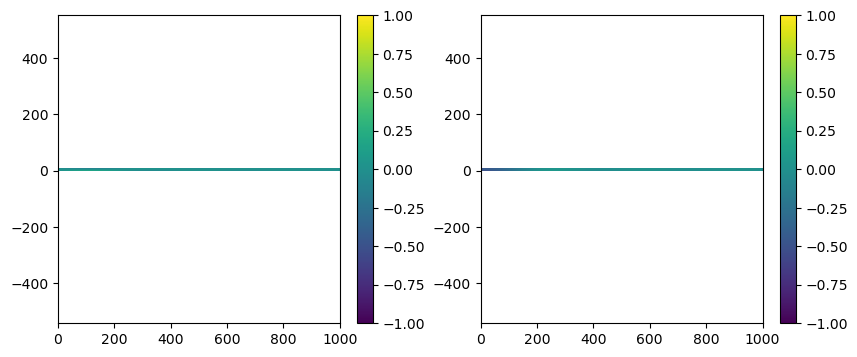

(0.0, 1000.0, 0.0, 10.0)

In [388]:
subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G_ref_tti.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G_ref_tti.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

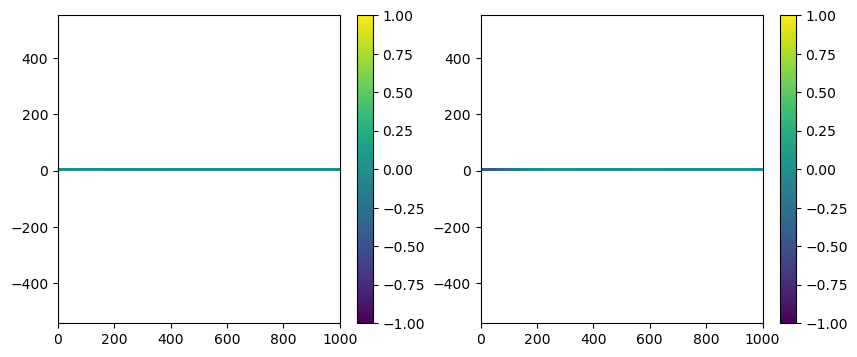

(0.0, 1000.0, 0.0, 10.0)

In [389]:
subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")